In [1]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NFT, ADAM, SPSA
from qiskit.aqua.operators import Z2Symmetries

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator

provider = IBMQ.load_account()

import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings;
warnings.filterwarnings('ignore');

In [3]:
# Calculate HLi parameters in PySCF
# Modified from Qiskit textbook

def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [4]:
# Calculate theoretical values from eigensolver

def exact_eng(distance, exact_energies):
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(distance)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    return exact_energies

In [5]:
# Define initial state

def get_init_state(num_spin_orbitals, num_particles):
    inits = HartreeFock(
                num_spin_orbitals,
                num_particles,
                qubit_mapping='parity'
    )
    return inits

In [6]:
# Define ansatzes

def get_var_form(var_type, num_spin_orbitals, num_particles, initial_state):
    if var_type == "UCCSD":
        vf = UCCSD(
                    num_orbitals=num_spin_orbitals,
                    num_particles=num_particles,
                    initial_state=initial_state,
                    qubit_mapping='parity'
        )
    else:
        raise RuntimeError("Unsupported ansatz")
    return vf

In [7]:
# Callback function to track # evaluations

def vqe_run_callback(qubitOp, var_form, optimizers, opt, backend, shift):
    itrs = []
    vals = []
    stdevs = []
    
    def get_eval_result(num_eval, params, mean, std):
        itrs.append(num_eval)
        vals.append(mean)
        stdevs.append(std)
    
    vqe = VQE(qubitOp, var_form, optimizers[opt],callback=get_eval_result)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    return vqe_result, itrs, vals, stdevs

In [8]:
# Main

def vqe_test(distance, optimizers, backend, ansatz_type):
    exact_energies = []
    vqe_energies = [[] for i in range(len(optimizers))]
    vqe_result = []
    converge_itrs = [[] for i in range(len(optimizers))]
    converge_vals = [[] for i in range(len(optimizers))]
    converge_stdevs = [[] for i in range(len(optimizers))]
    
    n = 0
    ct = datetime.datetime.now()
    print("Start - ",ct)
    exact_eng(distance, exact_energies)
    for opt in optimizers:
        qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(distance)
        initial_state = get_init_state(num_spin_orbitals, num_particles)
        var_form = get_var_form(ansatz_type, num_spin_orbitals, num_particles, initial_state)
            
        vqe_result, converge_itrs[n], converge_vals[n], converge_stdevs[n] = vqe_run_callback(qubitOp, var_form, optimizers, opt, backend, shift)
        vqe_energies[n].append(vqe_result)

        n += 1
        ct = datetime.datetime.now()
        print(opt,"Finish - ",ct)

    print("VQE Complete")
    return exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs

In [9]:
# Number of evaluations per optimizer at equilibrium distance d = 1.6 Angstroms

def plot_iterations(opt_labels, converge_itrs, converge_vals):
    for i in range(len(opt_labels)):
        plt.plot(converge_itrs[i], converge_vals[i], label="VQE Energy - %s" % (opt_labels[i]))
    plt.xlabel('Eval Count')
    plt.ylabel('Energy Difference')
    plt.title('VQE Convergence')
    plt.legend()
    plt.show()

In [10]:
backend = BasicAer.get_backend("qasm_simulator")
ds = 1.6
os = {"SLSQP":SLSQP(maxiter=5),
      "COBYLA":COBYLA(maxiter=500, disp=False, rhobeg=1.0, tol=0.2),
      "SPSA":SPSA(maxiter=50, save_steps=1, last_avg=1, c0=1.0, c1=0.1, c2=0.15, c3=0.02, c4=-0.4, skip_calibration=True)}

exact_energies, vqe_energies, converge_itrs, converge_vals, converge_stdevs = vqe_test(distance = ds, optimizers = os, backend = backend, ansatz_type = "UCCSD")

Start -  2021-01-27 21:59:57.102241
SLSQP Finish -  2021-01-27 22:00:23.195814
COBYLA Finish -  2021-01-27 22:01:08.851206
SPSA Finish -  2021-01-27 22:04:48.572063
VQE Complete


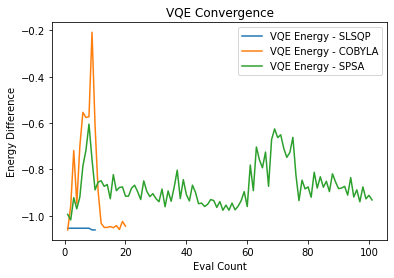

In [13]:
plot_iterations(opt_labels = ["SLSQP","COBYLA","SPSA"], converge_itrs = converge_itrs, converge_vals = converge_vals)